# Springboard Data Science Track Capstone Project 1
### Histopathologic Cancer Detection
### by Morgan Fry
### Statistical Analysis notebook

In [1]:
#includes
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt 
import matplotlib.patches as patches
%matplotlib inline

from matplotlib.image import imread
import cv2    

from sklearn.utils import shuffle
import pickle
import sys
import seaborn as sns

import pymc3 as pm
import arviz as az

from numpy.random import seed
from scipy.stats import gamma
from scipy.stats import poisson

In [2]:
#load data saved in data wrangling notebook
y=pickle.load(open("y_s.p","rb"))
X=pickle.load(open("X_s.p","rb"))

In [3]:
#first sort the positive and negative slides into lists. 
X_p,X_n=[],[]
for idx,row in y.iterrows():
    if row.label==1:
        X_p.append(X.get(row.id))       
    else:
        X_n.append(X.get(row.id))

#then each 2d array into 1d
X_p_v=[a.flatten() for a in X_p]
X_n_v=[a.flatten() for a in X_n]

In [4]:
#make grayscale and flatten
X_gr_p=[]
for each in X_p:
    X_gr_p.append(cv2.cvtColor(each, cv2.COLOR_BGR2GRAY))

X_gr_p_v=[a.flatten() for a in X_gr_p]

In [5]:
#plot a reminder of what the aggregate data look like

X_p_mean=[np.mean(each) for each in X_p_v]
X_n_mean=[np.mean(each) for each in X_n_v]
X_p_var=[np.var(each) for each in X_p_v]
X_n_var=[np.var(each) for each in X_n_v]

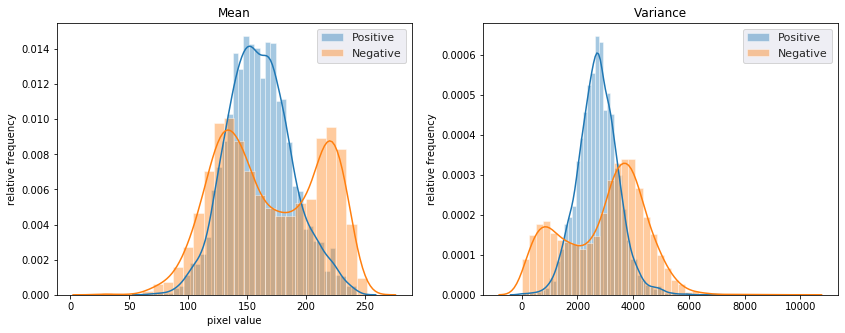

In [6]:
fig,axs = plt.subplots(1,2, figsize=(14,5))
sns.set()
sns.distplot(X_p_mean,label='Positive',ax=axs[0]).set_title('Mean')
sns.distplot(X_n_mean,label='Negative',ax=axs[0])
sns.distplot(X_p_var,label='Positive',ax=axs[1]).set_title('Variance')
sns.distplot(X_n_var,label='Negative',ax=axs[1])


axs[0].set_ylabel('relative frequency')
axs[0].set_xlabel('pixel value')
axs[1].set_ylabel('slide variance')
axs[1].set_ylabel('relative frequency')
axs[0].legend(labels=['Positive','Negative'])
axs[1].legend(labels=['Positive','Negative'])
plt.show()

In [7]:
#number of positive samples for later
n_pos=len(X_p)

In [8]:
#using poisson distribution of image means

#beginning estimate for lambda  
lambda_est=np.mean(X_p_mean)

In [9]:
poi_rvs=poisson(lambda_est).rvs(n_pos)

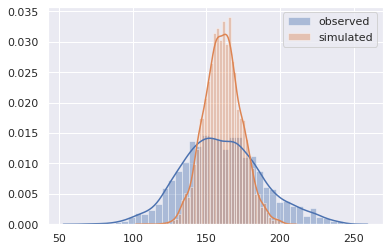

In [10]:
sns.distplot(X_p_mean,label='observed')
sns.distplot(poi_rvs,label='simulated')

plt.legend(labels=['observed','simulated'])
plt.show()

In [24]:
#priors for gamma distribution
alpha_est=np.mean(X_p_mean)**2/np.var(X_p_mean)
beta_est=np.var(X_p_mean)/np.mean(X_p_mean)

x=np.linspace(start=0,stop=255,num=n_pos)

prior=gamma.pdf(x,a=alpha_est,scale=1/beta_est)

array([0.00000000e+00, 3.04368808e-55, 2.57255436e-45, ...,
       0.00000000e+00, 0.00000000e+00, 0.00000000e+00])

In [23]:
with pm.Model() as model:
    lambda_=pm.Gamma('lambda_',alpha=alpha_est,beta=beta_est)
    simulated_positive_=pm.Poisson('simulated_positive_',mu=prior,observed=X_p_mean)
    trace=pm.sample(draws=10000,chains=4)

ValueError: The model does not contain any free variables.

In [19]:
lambda_post=trace['lambda_']
ci95_l=np.percentile(lambda_post,[2.5,97.5])

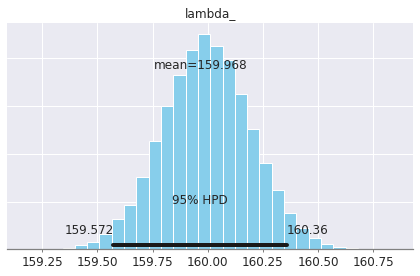

In [20]:
_=pm.plot_posterior(trace)

In [21]:
simulated_positive

simulated_positive

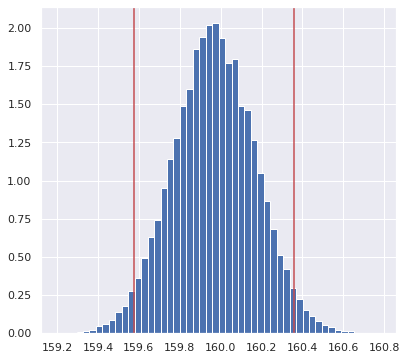

In [54]:
plt.figure(figsize=(14,6))
plt.subplot(2,1,1)
_=plt.plot(lambda_post)
_=plt.title(r'$\lambda$ line plot')
_=plt.xlabel('iterations')
_=plt.ylabel(r'$\lambda$')

plt.subplot(1,2,1)
_=plt.hist(lambda_post,bins=50,density=True)
_=plt.axvline(ci95_l[0],color='r')
_=plt.axvline(ci95_l[1],color='r')
plt.show()

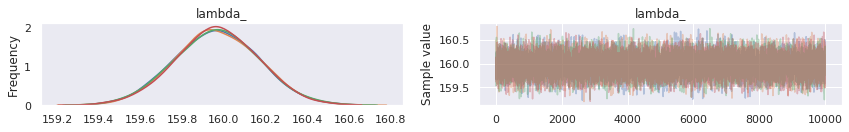

In [56]:
_=pm.plots.traceplot(trace)

In [26]:
poi_post=poisson(np.mean(lambda_post)).rvs(n_pos)

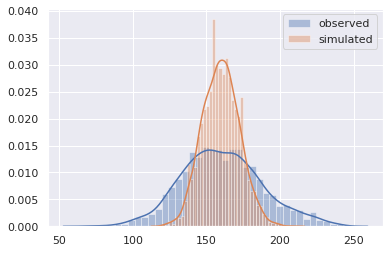

In [27]:
sns.distplot(X_p_mean,label='observed')
sns.distplot(poi_post,label='simulated')

plt.legend(labels=['observed','simulated'])
plt.show()

In [60]:
#try the same with grayscale

